In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf

# Enable GPU memory growth if GPU is available
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("✅ GPU memory growth enabled.")
    except:
        print("⚠️ Could not set GPU memory growth.")
else:
    print("🖥️ Running on CPU.")


✅ GPU memory growth enabled.


In [3]:
# From SKlearns website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Add text labels inside the boxes
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [4]:
# # Organize data into train, valid, test dirs
# os.chdir('data/Gesture_data/Gesture Image Data/')

# # Create main directories if they don't exist
# os.makedirs('train', exist_ok=True)
# os.makedirs('valid', exist_ok=True)
# os.makedirs('test', exist_ok=True)

# # Get all class directories (0-9, A-Z)
# class_dirs = [str(i) for i in range(10)] + [chr(i) for i in range(ord('A'), ord('Z')+1)]
# valid_classes = [d for d in class_dirs if os.path.isdir(d)]

# for class_dir in valid_classes:
#     # Create directories in train, valid, test
#     os.makedirs(f'train/{class_dir}', exist_ok=True)
#     os.makedirs(f'valid/{class_dir}', exist_ok=True)
#     os.makedirs(f'test/{class_dir}', exist_ok=True)
    
#     # Get all images in this class
#     images = os.listdir(class_dir)
#     total_images = len(images)
    
#     # Check if we have enough images
#     if total_images < 1500:  # 800 + 500 + 200
#         print(f"Warning: Class {class_dir} only has {total_images} images, not enough for the required distribution.")
        
#         # Determine how many images we can use for each split
#         # Maintaining roughly the 8:5:2 ratio
#         total_ratio = 800 + 500 + 200  # 1500
#         train_count = min(800, int((800/total_ratio) * total_images))
#         valid_count = min(500, int((500/total_ratio) * total_images))
#         test_count = min(total_images - train_count - valid_count, 200)
#     else:
#         # We have enough images
#         train_count = 800
#         valid_count = 500
#         test_count = 200
    
#     # Shuffle images for random selection
#     random.shuffle(images)
    
#     # Select images for each split
#     train_images = images[:train_count]
#     valid_images = images[train_count:train_count+valid_count]
#     test_images = images[train_count+valid_count:train_count+valid_count+test_count]
    
#     # Move images to respective directories
#     for img in train_images:
#         shutil.copy(f'{class_dir}/{img}', f'train/{class_dir}/{img}')
    
#     for img in valid_images:
#         shutil.copy(f'{class_dir}/{img}', f'valid/{class_dir}/{img}')
    
#     for img in test_images:
#         shutil.copy(f'{class_dir}/{img}', f'test/{class_dir}/{img}')
    
#     print(f"Class {class_dir}: {len(train_images)} train, {len(valid_images)} valid, {len(test_images)} test")

# # Clean up original directories after copying
# for class_dir in valid_classes:
#     shutil.rmtree(class_dir)

# # Go back to the original directory
# os.chdir('../..')

In [5]:
train_path = 'data/Gesture_data/Gesture_Image_Data/train'
valid_path = 'data/Gesture_data/Gesture_Image_Data/valid'
test_path = 'data/Gesture_data/Gesture_Image_Data/test'

In [6]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 28800 images belonging to 36 classes.
Found 18000 images belonging to 36 classes.
Found 7200 images belonging to 36 classes.


In [7]:
assert train_batches.n == 28800 
assert valid_batches.n == 18000 
assert test_batches.n == 7200 

# Modify Model

In [8]:
mobile = tf.keras.applications.mobilenet_v2.MobileNetV2()

In [9]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [10]:
x = mobile.layers[-5].output

In [11]:
x = tf.keras.layers.Reshape(target_shape=(62720,))(x)  ## 7*7*1280 = 62720
output = Dense(units=36, activation='softmax')(x)

In [12]:
model = Model(inputs=mobile.input, outputs=output)

In [13]:
for layer in model.layers[:-22]:
    layer.trainable = False

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [15]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
model.fit(x=train_batches,
            steps_per_epoch=len(train_batches),
            validation_data=valid_batches,
            validation_steps=len(valid_batches),
            epochs=30,
            verbose=2
)

Epoch 1/30
2880/2880 - 224s - loss: 0.0684 - accuracy: 0.9887 - val_loss: 1.2349e-04 - val_accuracy: 0.9999 - 224s/epoch - 78ms/step
Epoch 2/30
2880/2880 - 53s - loss: 0.0394 - accuracy: 0.9965 - val_loss: 0.0602 - val_accuracy: 0.9974 - 53s/epoch - 18ms/step
Epoch 3/30
2880/2880 - 53s - loss: 0.0426 - accuracy: 0.9975 - val_loss: 0.0035 - val_accuracy: 0.9997 - 53s/epoch - 18ms/step
Epoch 4/30
2880/2880 - 52s - loss: 0.0370 - accuracy: 0.9978 - val_loss: 0.0021 - val_accuracy: 0.9998 - 52s/epoch - 18ms/step
Epoch 5/30
2880/2880 - 52s - loss: 0.0120 - accuracy: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9999 - 52s/epoch - 18ms/step
Epoch 6/30
2880/2880 - 52s - loss: 0.0273 - accuracy: 0.9987 - val_loss: 0.0040 - val_accuracy: 0.9996 - 52s/epoch - 18ms/step
Epoch 7/30
2880/2880 - 52s - loss: 0.0413 - accuracy: 0.9990 - val_loss: 3.3822e-04 - val_accuracy: 0.9999 - 52s/epoch - 18ms/step
Epoch 8/30
2880/2880 - 52s - loss: 0.0268 - accuracy: 0.9992 - val_loss: 0.0012 - val_accuracy: 0.999

# Predict sign language

In [17]:
test_labels = test_batches.classes

In [18]:
prediction = model.predict(x=test_batches, verbose=0)

In [19]:
cm = confusion_matrix(y_true=test_labels, y_pred=prediction.argmax(axis=1))

In [20]:
test_batches.class_indices

{'0': 0,
 '1': 1,
 '2': 2,
 '3': 3,
 '4': 4,
 '5': 5,
 '6': 6,
 '7': 7,
 '8': 8,
 '9': 9,
 'A': 10,
 'B': 11,
 'C': 12,
 'D': 13,
 'E': 14,
 'F': 15,
 'G': 16,
 'H': 17,
 'I': 18,
 'J': 19,
 'K': 20,
 'L': 21,
 'M': 22,
 'N': 23,
 'O': 24,
 'P': 25,
 'Q': 26,
 'R': 27,
 'S': 28,
 'T': 29,
 'U': 30,
 'V': 31,
 'W': 32,
 'X': 33,
 'Y': 34,
 'Z': 35}

Confusion matrix, without normalization
[[200   0   0 ...   0   0   0]
 [  0 200   0 ...   0   0   0]
 [  0   0 200 ...   0   0   0]
 ...
 [  0   0   0 ... 200   0   0]
 [  0   0   0 ...   0 200   0]
 [  0   0   0 ...   0   0 200]]


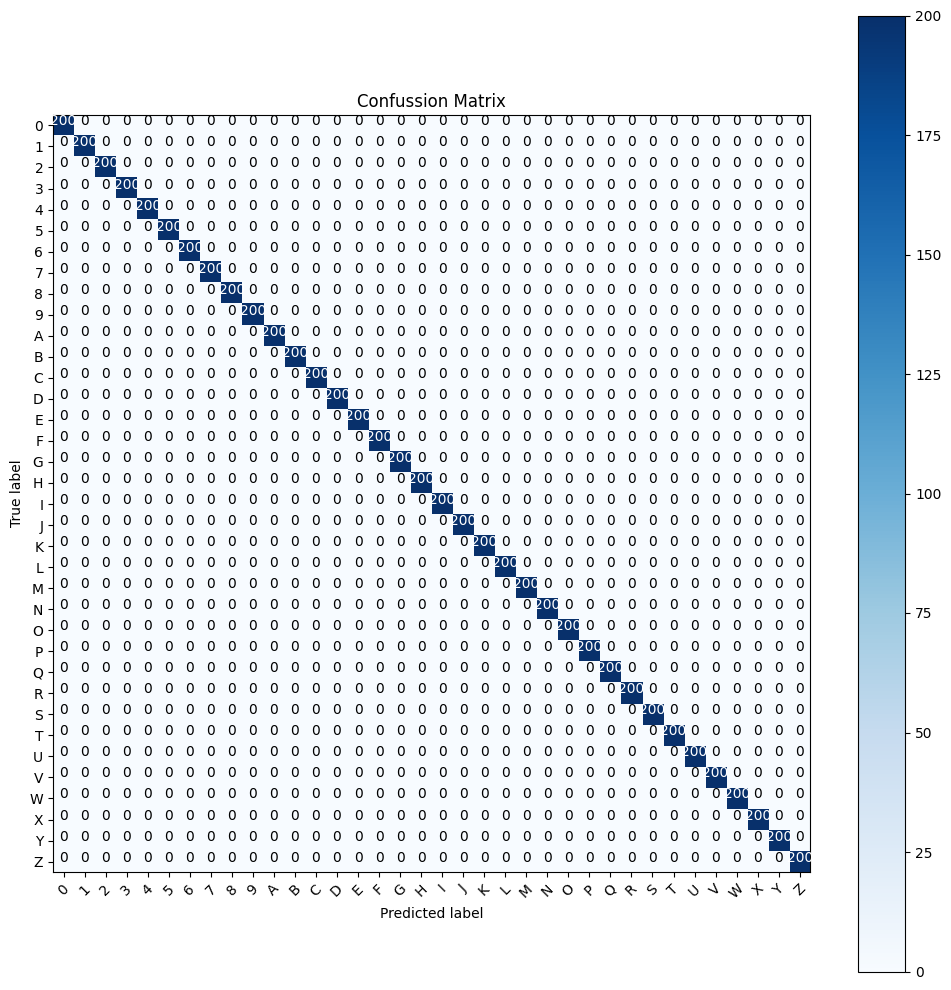

In [21]:
cm_plot_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L','M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confussion Matrix')

In [22]:
model.save('models/Sign_Language_recognition_model.h5')